## preprocessing

In [ ]:
import pandas as pd

df = pd.read_csv('./origin/감정 분류를 위한 대화 음성 데이터셋/5차년도.csv', encoding='cp949')

# #EDC
# df['label'] = df['감정_대분류'].map({'기쁨': '0', '당황': '1', '분노': '2', '불안': '3', '상처': '4', '슬픔': '5'})
# df['document'] = df['사람문장1']

# # DVforEC5()
# df['label'] = df['1번 감정'].map({'Angry': '0', 'Disgust': '1', 'Fear': '2', 'Happiness': '3', 'Neutral': '4', 'Sadness': '5', 'Surpise':'6'})
# df['document'] = df['발화문']

#DVforEC(4_8l)
df['label'] = df['1번 감정'].map({'Angry': '0', 'Sadness': '1', 'Fear': '2', 'Hurt': '3', 'embarrassed': '4', 'Happiness': '5', 'Thankful':'6','Peaceful':'7'})
df['document'] = df['발화문']

# a1.csv 파일로 저장
df[['label', 'document']].to_csv('./preprocess/DVforEC_pp.csv', index=False, encoding='utf-8-sig')


### count_item

In [10]:
import pandas as pd

def count_items(file_name, column_name):
    df = pd.read_csv(file_name)
    item_counts = df[column_name].value_counts()
    return item_counts

print(count_items('./preprocess/DVforEC(4_8l)_train.csv','label'))

label
7    2758
5    2598
1    2567
2    2554
0    2545
3    2544
4    2410
6    2357
Name: count, dtype: int64


### count_items_visualization

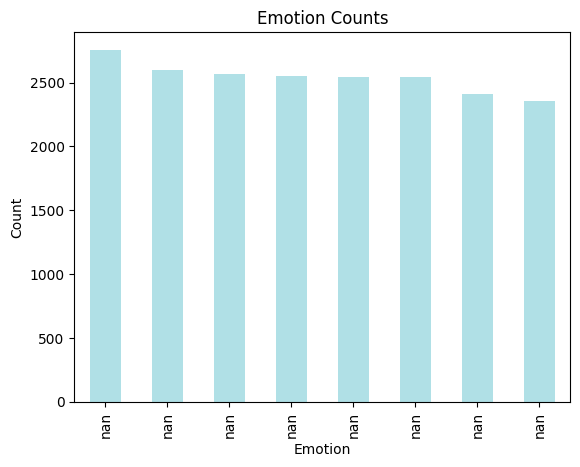

None


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# #EDC
# emotion_map = {0: 'joy', 1: 'embarrassed ', 2: 'anger', 3: 'nervous', 4: 'hurt', 5: 'sad'}

# #DVforEC
# emotion_map = {0: 'Angry', 1: 'Disgust ', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surpise'}

#DVforEC(4_8l)
emotion_map = {'0': 'Angry', '1': 'Sadness', '2': 'Fear', '3': 'Hurt', '4': 'embarrassed', '5': 'Happiness', '6':'Thankful','7':'Peaceful'}

def count_items_visualization(file_name, column_name):

    counts = count_items(file_name, column_name)
    counts.index = counts.index.map(emotion_map)

    # 시각화 (막대 그래프)
    counts.plot(kind='bar', color='powderblue')
    
    plt.title('Emotion Counts')
    plt.xlabel('Emotion')
    plt.ylabel('Count')

    plt.show()

print(count_items_visualization('./preprocess/DVforEC(4_8l)_train.csv','label'))


### onehot encoding

In [7]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))

from constants import ID2LABEL_KOR, ID2LABEL_EN

# CSV 파일 읽기
df = pd.read_csv('./preprocess/DVforEC(4_8l)_pp.csv')

# 각 레이블에 따라 0 또는 1을 가진 열 추가
for label_id, label_name in ID2LABEL_EN.items():
    df[label_name] = (df['label'] == label_id).astype(int)

df.to_csv('./preprocess/DVforEC(4_8l)_pp.csv', index=False, encoding='utf-8-sig')

print(ID2LABEL_EN)
print("complete onehot encoding")

{0: 'Angry', 1: 'Sadness', 2: 'Fear', 3: 'Hurt', 4: 'embarrassed', 5: 'Happiness', 6: 'Thankful', 7: 'Peaceful'}
complete onehot encoding


## train, test, val 데이터셋 구성
test(테스트), val(검증)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 원본 데이터셋 로드
data_path = './preprocess/DVforEC(4_8l)_pp.csv'  # 원본 CSV 파일 경로를 지정하세요.
data = pd.read_csv(data_path)

# 데이터셋을 train (70%), val (15%), test (15%)로 나누기
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% 훈련용 데이터
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 나머지 30%에서 50%씩 나누기

# 데이터셋을 각각의 CSV 파일로 저장
train_data.to_csv('./preprocess/DVforEC(4_8l)_train.csv', index=False, encoding='utf-8-sig')
val_data.to_csv('./preprocess/DVforEC(4_8l)_val.csv', index=False, encoding='utf-8-sig')
test_data.to_csv('./preprocess/DVforEC(4_8l)_test.csv', index=False, encoding='utf-8-sig')

print("Train, Validation, and Test datasets have been created and saved.")


Train, Validation, and Test datasets have been created and saved.
